In [1]:
##################################
#                                #
# regression.ipynb               #
# Created 2022-07-10             #
# Akhil Garg, akhil@akhilgarg.ca #
#                                #
##################################

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn import metrics

import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
data = pd.read_excel('AMR_imputation_6.xlsx').drop('#',axis='columns')
data

,Anonymous_ID,Episode,AgeCat,Sex,YearOfAdmission,NumberOfBacteremiasLastYear,Medical(1) Surgical (2) Admitting Service,MRSA12months,VRE12months,ESBL12months,...,Daptomycin_PGNO_imp,Vancomycin_PGNO_imp,Linezolid_PGNO_imp,Amikacin_PGNO_imp,Tobramycin_PGNO_imp,Gentamicin_PGNO_imp,Clindamycin_PGNO_imp,Doxycycline_PGNO_imp,Erythromycin_PGNO_imp,TMPSMX_PGNO_imp
0,1,1,85-90,M,2008,0,1,no_data,no_data,no_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,85-90,M,2008,0,1,no_data,no_data,no_data,...,RESISTANT,no_data,RESISTANT,no_data,SUSCEPTIBLE,SUSCEPTIBLE,RESISTANT,no_data,RESISTANT,SUSCEPTIBLE
2,2,9,>90,M,2011,0,1,no_data,no_data,no_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,15,>90,M,2012,0,1,no_data,no_data,no_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,25,45-50,F,2013,0,1,0,0,no_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5766,4357,13584,70-75,F,2021,2,1,0,0,no_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5767,4358,13585,70-75,M,2021,0,1,no_data,no_data,no_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5768,4359,13586,>90,F,2021,0,1,0,0,no_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5769,4360,13587,80-85,M,2021,0,1,no_data,no_data,no_data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Only keep data prior to a change in the micro lab reporting system
data2019 = data[data['Episode'] <= 7217]

# List of output antibiotics
output_antibiotics = ['Penicillin_FINAL_imp','Amoxiclav_FINAL_imp','Ampicillin_FINAL_imp','Cloxacillin_FINAL_imp','Piptaz_FINAL_imp','Cefazolin_FINAL_imp','Ceftriaxone_FINAL_imp','Ceftazidime_FINAL_imp','Ertapenem_FINAL_imp','Meropenem_FINAL_imp','Ciprofloxacin_FINAL_imp','Levofloxacin_FINAL_imp','Moxifloxacin_FINAL_imp','Daptomycin_FINAL_imp','Vancomycin_FINAL_imp','Linezolid_FINAL_imp','Amikacin_FINAL_imp','Tobramycin_FINAL_imp','Gentamicin_FINAL_imp','Clindamycin_FINAL_imp','Doxycycline_FINAL_imp','Erythromycin_FINAL_imp','TMPSMX_FINAL_imp']

# Missingness susceptibilities for each antibiotic
print('Missingness')
for abx in output_antibiotics:
    missingness = data2019[data2019[abx]=='no_data'].shape[0] / data2019.shape[0]
    print('{:<15} {:>6.2f}%'.format(abx.split('_')[0],missingness*100))

Missingness
Penicillin        2.42%
Amoxiclav        35.25%
Ampicillin        1.01%
Cloxacillin       6.52%
Piptaz            1.28%
Cefazolin         1.44%
Ceftriaxone       0.54%
Ceftazidime       0.87%
Ertapenem         1.58%
Meropenem         0.50%
Ciprofloxacin     1.31%
Levofloxacin     16.67%
Moxifloxacin      4.67%
Daptomycin        1.85%
Vancomycin        1.85%
Linezolid         1.85%
Amikacin          2.35%
Tobramycin        0.64%
Gentamicin        0.60%
Clindamycin       4.37%
Doxycycline      80.85%
Erythromycin     55.31%
TMPSMX            0.57%


## Data dictionary

Age category: ordinal integer between 1 and 12
    
      <40: 1 
    40-45: 2
    45-50: 3
    50-55: 4
    55-60: 5
    60-65: 6
    65-70: 7
    70-75: 8
    75-80: 9
    80-85: 10
    85-90: 11
      >90: 12  
Sex
    
    0 (male) or 1 (female)

ClincalMRSA, ClinicalVRE, ClinicalESBL,
RecentHospitalization, ICUExposure,
Prior[Antibiotic], PriorNon[Antibiotic]

    0 or 1

Medical(1) Surgical (2) Admitting Service

    1 or 2

Output
    
    0 (susceptible) or 1 (intermediate or resistant)

## Preprocessing

In [28]:
# Change missing data to be resistant
data2019[output_antibiotics] = data2019[output_antibiotics].replace('no_data','RESISTANT')

# Convert susceptible/intermediate/resistant to numerical categorical values
data2019 = data2019.replace({'SUSCEPTIBLE':0,'INTERMEDIATE':1,'RESISTANT':1})

# Create categorical variable columns
# Encode ages as integer variables
ages = {'<40':1, '40-45':2, '45-50':3, '50-55':4, '55-60':5, '60-65':6, 
        '65-70':7, '70-75':8, '75-80':9, '80-85':10, '85-90':11, '>90':12}
data2019['Age'] = data2019['AgeCat'].map(ages)

# Encode sex as male=0, female=1
sexes = {'M':0,'F':1}
data2019['SexCat'] = data2019['Sex'].map(sexes)
data2019

# Encode culture type
culture_types = {'BLDC':1,'URCR':2,'BCPOS':1,'CSFCS':3,'URCC':2,
                 'FLDC':3,'BONEC':3,'BXTC' :3,'EARC':3,'FLDBC':3,
                 'FUNC':3,'GMISC':3,'DIALC':3,'INCC':3,'LRESC':3,
                 'ORCU':3,'STCS' :3,'TDRNC':3,'VTIPC':3}
data2019['CultureSource'] = data2019['culture_test_cd'].map(culture_types)

# Create new categories of "prior non-[antibiotic class]"
data2019['PriorNonCephalosporin'] = data2019[['PriorAMG','PriorCarbapenem','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
data2019['PriorNonCarbapenem'] = data2019[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
data2019['PriorNonPenicillin'] = data2019[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonFQ'] = data2019[['PriorAMG','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')

# Converts True/False into 1/0
data2019['PriorNonCephalosporin'] = data2019['PriorNonCephalosporin'].apply(int)
data2019['PriorNonCarbapenem']    = data2019['PriorNonCarbapenem'].apply(int)
data2019['PriorNonPenicillin']    = data2019['PriorNonPenicillin'].apply(int)
data2019['PriorNonFQ']            = data2019['PriorNonFQ'].apply(int)

data2019 = data2019.drop(['MRSA12months','VRE12months','ESBL12months','MRSA7days','VRE7days','ESBL7days',
                          'NumberOfBacteremiasLastYear','ClincalMRSA','ClinicalVRE'],axis=1,errors='ignore')
data2019

,Anonymous_ID,Episode,AgeCat,Sex,YearOfAdmission,Medical(1) Surgical (2) Admitting Service,ClinicalESBL,RecentHospitalization,ICUExposure,PriorAMG,...,Erythromycin_PGNO_imp,TMPSMX_PGNO_imp,Age,SexCat,CultureSource,PriorNonCephalosporin,PriorNonCarbapenem,PriorNonPenicillin,PriorNonFQ,PriorGNresistance
0,1,1,85-90,M,2008,1,0,0,0,0,...,NaN,NaN,11,0,2,1,1,0,1,0
1,1,2,85-90,M,2008,1,0,0,0,0,...,1,0.0,11,0,2,1,1,1,1,0
2,2,9,>90,M,2011,1,0,0,0,0,...,NaN,NaN,12,0,2,0,0,0,0,0
3,3,15,>90,M,2012,1,0,0,0,0,...,NaN,NaN,12,0,2,0,0,0,0,0
4,4,25,45-50,F,2013,1,0,0,0,0,...,NaN,NaN,3,1,2,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,2313,7212,60-65,M,2019,1,0,0,0,0,...,NaN,NaN,6,0,2,0,0,0,0,0
2972,2314,7215,75-80,M,2019,1,0,1,0,0,...,NaN,NaN,9,0,1,0,0,0,0,0
2973,2314,7215,75-80,M,2019,1,0,1,0,0,...,NaN,NaN,9,0,2,0,0,0,0,0
2974,2314,7216,75-80,M,2019,1,0,1,1,0,...,no_data,1.0,9,0,1,1,1,1,1,0


In [29]:
# List of antibiotics to run regression on
antibiotic_list = ['Cefazolin','Ceftriaxone','Ceftazidime','Piptaz','Meropenem','Ciprofloxacin']
antibiotic_classes = {'Cefazolin':'Cephalosporin','Ceftriaxone':'Cephalosporin','Ceftazidime':'Cephalosporin',
                      'Piptaz':'Penicillin','Meropenem':'Carbapenem','Ciprofloxacin':'FQ'}

# Regression Function

In [30]:
# Look for antibiotic resistance during previous gram negative infection
def previous_infection(priorGNOrg,prior_susceptibility):
    '''
    For a given antibiotic, takes a previous gram negative organism and its susceptibility as input
    Outputs:
        0 if no previous gram negative organism
        0 if previous susceptible gram negative organism
        1 if previous resistant gram negative organism
        1 if previous gram negative organism without susceptibility data
    '''
    
    if priorGNOrg=='no_data': return 0
    elif prior_susceptibility=='no_data': 
        return 1
    else: return prior_susceptibility

Regression model for Cefazolin

Logistic Regression Coefficients
PriorGNresistance                           1.4913
ClinicalESBL                                1.0637
PriorCephalosporin                          0.5475
ICUExposure                                 0.3697
Medical(1) Surgical (2) Admitting Service   0.3325
PriorNonCephalosporin                       0.1168
Age                                        -0.0567
RecentHospitalization                      -0.1624
SexCat                                     -0.4152


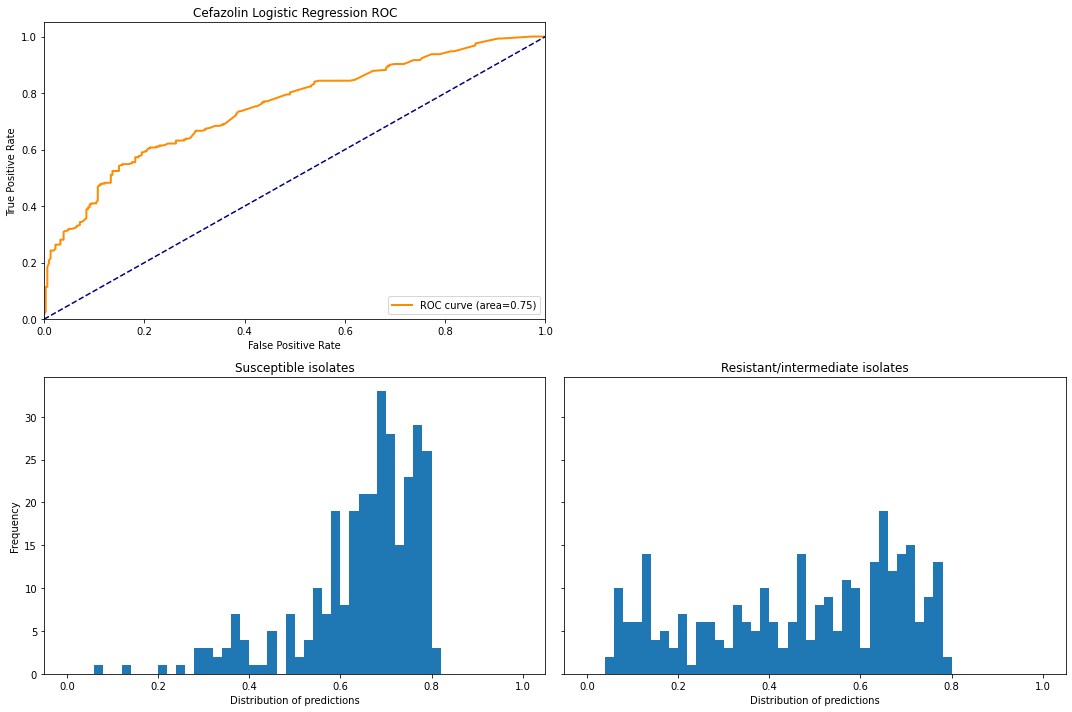

In [ ]:
def antibiotic_susceptibility_regression(antibiotic):
    
    print('Regression model for {}\n'.format(antibiotic))
    
    # Add a column for previous susceptibility to the particular antibiotic
    data2019['PriorGNresistance'] = data2019.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)
    
    regression_inputs = ['Age','SexCat','Medical(1) Surgical (2) Admitting Service','ClinicalESBL',
                         'RecentHospitalization','ICUExposure','PriorGNresistance',
                         'Prior'+antibiotic_classes[antibiotic],'PriorNon'+antibiotic_classes[antibiotic]]
        
    # Divide data into 80-20 train-test sets
    train_set, test_set= np.split(data2019, [int(.8 *len(data2019))])

    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']
        
    reg = linear_model.LogisticRegression()
    reg.fit(X_train,Y_train)

    # Coefficients sorted by size
    print('Logistic Regression Coefficients')
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<42} {: .4f}'.format(i[1],i[0]))
        
    # Calculate and plot ROC
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
    AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))

    fig, ax = plt.subplots(nrows=2, ncols=2, sharey = "row", figsize=(15,10))

    ax[0,0].plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,0].set_xlim([0.0, 1.0])
    ax[0,0].set_ylim([0.0, 1.05])
    ax[0,0].set_xlabel("False Positive Rate")
    ax[0,0].set_ylabel("True Positive Rate")
    ax[0,0].set_title("{} Logistic Regression ROC".format(antibiotic))
    ax[0,0].legend(loc="lower right")
    
    ax[0,1].set_axis_off()
    
    # Zip together prediction values and actual test values
    # Then sort by susceptible strains first, followed by prediction values
    predict_results = sorted((zip(reg.predict_proba(X_test)[:,0],Y_test)),key=lambda x: (x[1],x[0]))

    # Separate out predictions on susceptible and resistant isolates
    susceptible_isolates = []
    resistant_isolates   = []
    for i in predict_results:
        if i[1]==1:
            resistant_isolates.append(i[0])
        else: susceptible_isolates.append(i[0])

    # Plot a histogram of predictions on susceptible and resistant isolates    
    range = (0,1)
    bins = 50

    ax[1,0].hist(susceptible_isolates,
             bins=bins,range=range)
    ax[1,0].set_title('Susceptible isolates')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].set_xlabel('Distribution of predictions')

    ax[1,1].hist(resistant_isolates,
             bins=bins,range=range)
    ax[1,1].set_title('Resistant/intermediate isolates')
    ax[1,1].set_xlabel('Distribution of predictions')
    
    plt.tight_layout()
    plt.show()
    
for antibiotic in antibiotic_list:
    antibiotic_susceptibility_regression(antibiotic)